# Feature Extraction: Wavelet




## Setup

In [ ]:
!pip install webdataset


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 1.8 MB/s eta 0:00:00


In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 33.5 MB/s eta 0:00:00


In [ ]:
#import libraries
import webdataset as wds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2 as cv

from skimage import feature
from skimage import data, exposure
from skimage import filters

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble  import HistGradientBoostingClassifier

import seaborn as sns

import numpy as np
import pywt
from scipy.stats import skew, kurtosis, entropy

In [ ]:
# paths
root = '/content/drive/My Drive/DS 281 - CV/2024-12-01 281_Final-main'
data_folder = f'{root}/data'
feature_data_folder = f'{root}/feature_data'

# Google Drive
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/DS 281 - CV/2024-12-01 281_Final-main')

Mounted at /content/drive


In [ ]:
# #alternate paths
# root = '.'
# data_folder = f'{root}/data'
# feature_data_folder = f'{root}/data'

## Load Data

In [ ]:
def load_data(path_to_data: str):
    """
    load 2D images and their labels

    returns:
    images (array): array of images as np arrays
    labels (array): array of labels
    """
    #create lists to store images and labels
    images = []
    labels = []

    #load webdataset
    data = (wds.WebDataset(f'{path_to_data}', shardshuffle=True)
        .decode("pil")
        .to_tuple("jpg", "json")
        .map(lambda row: (np.array(row[0]), row[1]['label'])))

    #append dataset to lists
    for image, label in data:
        images.append(image)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)
    data.close()

    return images, labels

In [ ]:
train_images, train_labels = load_data(f'file:{data_folder}/train-000000.tar')
val_images, val_labels = load_data(f'file:{data_folder}/val-000000.tar')
test_images, test_labels = load_data(f'file:{data_folder}/test-000000.tar')

7


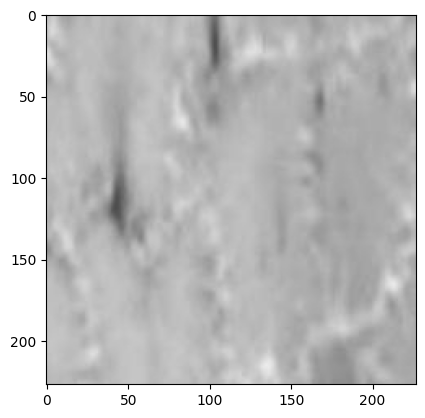

In [ ]:
print(train_labels[0])
plt.imshow(train_images[0])

In [ ]:
print("Shape of images:", train_images.shape)
print("Shape of labels:", train_labels.shape)

Shape of images: (8252, 227, 227, 3)
Shape of labels: (8252,)


## Quick EDA

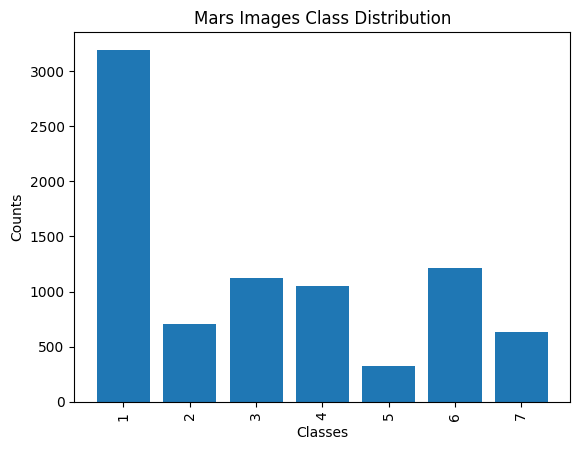

In [ ]:
unique, counts = np.unique(train_labels, return_counts=True)
class_dict = dict(zip(unique, counts))
#plot
plt.bar(range(len(class_dict)), list(class_dict.values()), align='center')
plt.xticks(range(len(class_dict)), list(class_dict.keys()), rotation = 'vertical')
plt.title('Mars Images Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.show()

# View Class Samples

In [ ]:
def plot_class_samples(images: list, labels: list):
    fig, axs = plt.subplots(nrows=1, ncols=len(images), figsize=(20,3))

    for i, (label, image) in enumerate(zip(labels, images)):
        ax = axs[i]
        ax.imshow(image)
        ax.set_title(label)
        ax.axis('off')

    fig.suptitle('One Image For Each Class')
    plt.show()

def load_class_samples(images: list, labels: list) -> tuple:
    label_names = ['crater', 'dark dune', 'slope streak', 'bright dune', 'impact ejecta', 'swiss cheese', 'spider']
    unique_labels = np.unique(labels)

    sample_images = []
    sample_labels = []

    for value in unique_labels:
        label = label_names[value - 1]
        index = int(np.where(train_labels==value)[0][0])

        sample_labels.append(label)
        sample_images.append(images[index])

    return sample_images, sample_labels

In [ ]:
sample_imgs, sample_lbls = load_class_samples(train_images, train_labels)

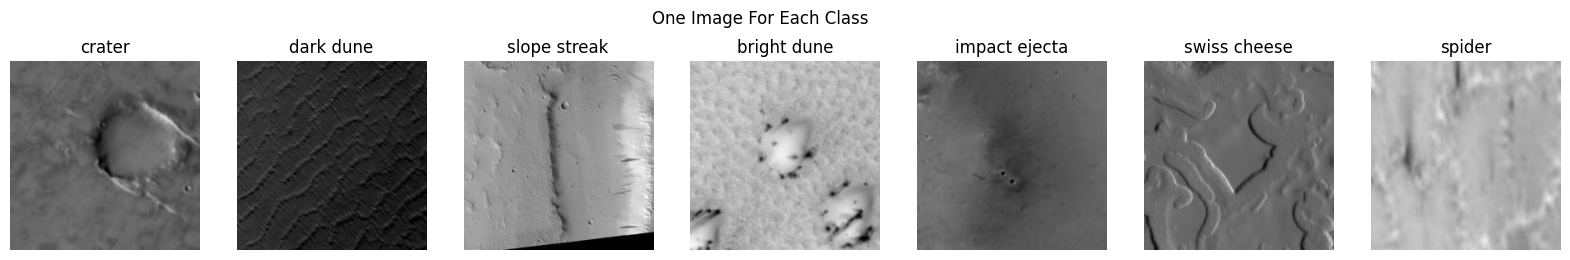

In [ ]:
plot_class_samples(sample_imgs, sample_lbls)

## Feature Extraction: Wavelet Transform


In [ ]:
def extract_wavelet_features(img_dataset, wavelet = 'db1'):
    """
    Extract wavelet features from an image dataset
    args: img_dataset (training / val / testing dataset)
          wavelet (default db1, Daubechies wavelet of order 1)
          level (default 2)
    returns: features extracted from each image
    """
    features_matrix = []
    for image in img_dataset:
      max_level = pywt.dwtn_max_level(image.shape, pywt.Wavelet(wavelet))
      coeffs = pywt.wavedec2(image, wavelet)
      features = []

      # Extract features at each level
      for i in range(max_level):
        (cH, cV, cD) = coeffs[i+1]
        for detail in (cH, cV, cD):
          features.extend([
            np.mean(np.abs(detail)), # Mean
            np.std(detail), # Std Dev
            skew(detail.ravel()), # Skewness
            kurtosis(detail.ravel()), # Kurtosis
            np.sum(detail**2) # Energy
          ])
      features_matrix.append(features)
    return np.array(features_matrix)

In [ ]:
train_wavelet = extract_wavelet_features(train_images)

In [ ]:
val_wavelet = extract_wavelet_features(val_images)

In [ ]:
test_wavelet = extract_wavelet_features(test_images)

In [ ]:
train_wavelet[0]

array([1.78410233e+00, 2.80089388e+00, 2.53785770e-01, 9.67743544e+00,
       4.06062000e+05, 0.00000000e+00, 0.00000000e+00,            nan,
                  nan, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
                  nan,            nan, 0.00000000e+00])

In [ ]:
# Tried Imputing, but didn't work

# from sklearn.impute import SimpleImputer
# from sklearn.pipeline import Pipeline
# from sklearn.decomposition import PCA

# # Create a pipeline that first imputes missing values, then applies PCA
# pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('pca', PCA())
# ])

# # Fit and transform the data
# transformed_features = pipeline.fit_transform(train_wavelet)

In [ ]:
train_wavelet = np.nan_to_num(train_wavelet, nan=0.0)
val_wavelet = np.nan_to_num(val_wavelet, nan=0.0)
test_wavelet = np.nan_to_num(test_wavelet, nan=0.0)


In [ ]:
train_wavelet[0]

array([1.78410233e+00, 2.80089388e+00, 2.53785770e-01, 9.67743544e+00,
       4.06062000e+05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [ ]:
np.save(f'{feature_data_folder}/train_images_wavelet.npy', train_wavelet)
np.save(f'{feature_data_folder}/val_images_wavelet.npy', val_wavelet)
np.save(f'{feature_data_folder}/test_images_wavelet.npy', test_wavelet)


## PCA


In [ ]:
pca = PCA()
pca.fit(train_wavelet)

PCA()

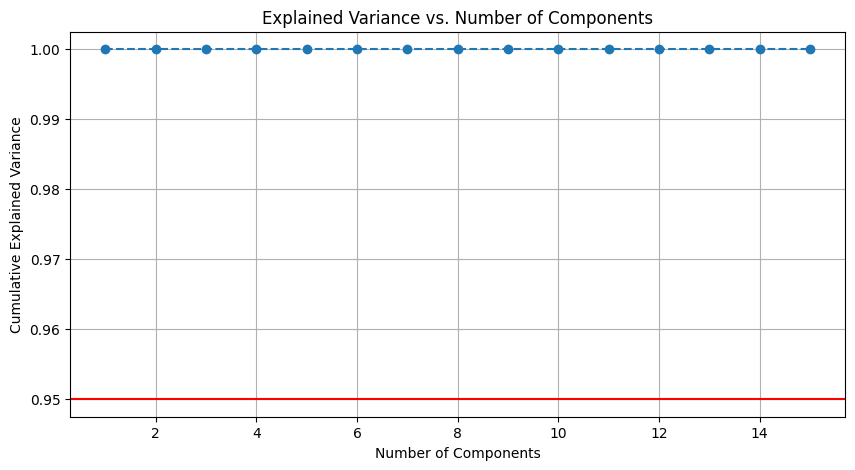

In [ ]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
# draw a line at 95% of explained variance
plt.axhline(y=0.95, color='r', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [ ]:
tsne = TSNE(n_components=2)
reduced_data = tsne.fit_transform(train_wavelet)

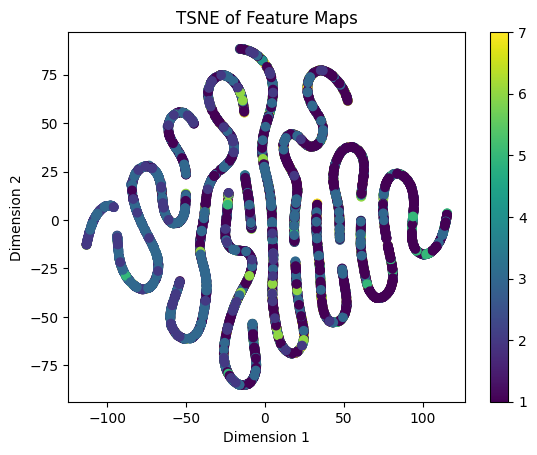

In [ ]:
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=train_labels, cmap='viridis', marker='o')
plt.title('TSNE of Feature Maps')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar()
plt.show()

## Predictive Power

In [ ]:
clf = SVC(kernel='rbf', C=1.0)
clf.fit(train_wavelet, train_labels)


SVC()

In [ ]:
clf.score(train_wavelet, train_labels)

0.3886330586524479

In [ ]:
clf.score(val_wavelet, val_labels)

0.4334053275737941

In [ ]:
preds = clf.predict(train_wavelet)
corr = preds == train_labels
df = pd.DataFrame({'correct': corr, 'label': train_labels})
df.head(50)


,correct,label
0,False,7
1,False,7
2,False,7
3,False,7
4,False,7
5,False,7
6,False,7
7,True,1
8,True,1
9,True,1


# Performance with HGBC

In [ ]:
clf = HistGradientBoostingClassifier(
    max_iter=150,
    learning_rate=0.08,
    class_weight='balanced').fit(train_wavelet, train_labels)

In [ ]:
clf.fit(train_wavelet, train_labels)

HistGradientBoostingClassifier(class_weight='balanced', learning_rate=0.08,
                               max_iter=150)

In [ ]:
clf.score(train_wavelet, train_labels)

0.9179592825981581

In [ ]:
clf.score(val_wavelet, val_labels)

0.5363570914326854